# Basic usage of the ``fakecbed`` library #

## A NOTE BEFORE STARTING ##

Since the ``fakecbed`` git repository tracks this notebook under its original
basename ``basic_usage.ipynb``, we recommend that you copy the original notebook
and rename it to any other basename that is not one of the original basenames
that appear in the ``<root>/examples`` directory before executing any of the
notebook cells below, where ``<root>`` is the root of the ``fakecbed``
repository. This way you can explore the notebook by executing and modifying
cells without changing the original notebook, which is being tracked by git.

## Import necessary modules ##

In [1]:
# For performing deep copies.
import copy



# For general array handling.
import numpy as np

# For creating distortion models.
import distoptica

# For creating Hyperspy markers.
import hyperspy.api as hs



# The library that is the subject of this demonstration.
import fakecbed

WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)


In [2]:
%matplotlib ipympl
%matplotlib ipympl

## Introduction ##

In this notebook, we demonstrate how one can use each function and class in the
``fakecbed`` library.

You can find the documentation for the ``fakecbed`` library
[here](https://mrfitzpa.github.io/fakecbed/_autosummary/fakecbed.html).  It is
recommended that you consult the documentation of this library as you explore
the notebook. Moreover, users should execute the cells in the order that they
appear, i.e. from top to bottom, as some cells reference variables that are set
in other cells above them.

## Using the ``fakecbed`` library ##

### Creating a fake CBED pattern ###

Let's create a discretized fake convergent beam electron diffraction (CBED)
pattern step by step.

First, let's specify the number of pixels across the discretized CBED
pattern. Note that in ``fakecbed``, it is assumed that the number of pixels in
the discretized CBED pattern from left to right is equal to the number of pixels
in the discretized CBED pattern from top to bottom.

In [3]:
num_pixels_across_pattern = 512

Next, let's specify the intensity pattern of the undistorted thermal diffuse
scattering (TDS) model.

In [4]:
kwargs = {"center": (0.480, 0.490),
          "widths": (0.060, 0.050, 0.070, 0.055),
          "rotation_angle": np.pi/3,
          "val_at_center": 50,
          "functional_form": "asymmetric_gaussian"}
undistorted_tds_peak_0 = fakecbed.shapes.Peak(**kwargs)

kwargs = {"center": (0.50, 0.51),
          "widths": (0.075, 0.060, 0.045, 0.055),
          "rotation_angle": np.pi,
          "val_at_center": 55,
          "functional_form": "asymmetric_lorentzian"}
undistorted_tds_peak_1 = fakecbed.shapes.Peak(**kwargs)



kwargs = {"peaks": (undistorted_tds_peak_0, undistorted_tds_peak_1),
          "constant_bg": 3}
undistorted_tds_model = fakecbed.tds.Model(**kwargs)

All public classes from the modules ``fakecbed.shapes`` and ``fakecbed.tds``,
that are subclasses of ``fakecbed.shapes.BaseShape`` represent intensity
patterns of undistorted shapes. For any instance of any such class, one can
evaluate the intensity pattern of the undistorted shape being represented at
fractional horizontal and vertical coordinates of any set of points in a
hypothetical undistorted image.

In [5]:
u_x = np.array(((0.30, 0.50, 0.60), 
                (0.50, 0.50, 0.45)))
u_y = np.array(((0.50, 0.55, 0.60), 
                (0.45, 0.40, 0.45)))

print(undistorted_tds_peak_0.eval(u_x, u_y))
print(undistorted_tds_peak_1.eval(u_x, u_y))
print(undistorted_tds_model.eval(u_x, u_y))

tensor([[ 0.1657, 27.9768,  2.9628],
        [37.8661, 15.0479, 33.4143]])
tensor([[ 2.3593, 29.0926,  3.3533],
        [11.8800,  2.9855,  9.5089]])
tensor([[ 5.5250, 60.0694,  9.3161],
        [52.7461, 21.0334, 45.9232]])


Note that all public classes in the library ``fakecbed`` are subclasses of
``fancytypes.PreSerializableAndUpdatable``, meaning that any instance of any
such subclass, except for ``fakecbed.shapes.BaseShape``, is pre-serializable,
can be constructed from a serializable representation, and has an updatable
subset of attributes. See
[here](https://mrfitzpa.github.io/fancytypes/_autosummary/fancytypes.PreSerializableAndUpdatable.html)
for a definition of pre-serialization, and the documentation for all the
attributes and methods associated with the class
``fancytypes.PreSerializableAndUpdatable``.

With our TDS model, we can begin to construct our discretized CBED pattern.

In [6]:
kwargs = {"num_pixels_across_pattern": num_pixels_across_pattern,
          "undistorted_tds_model": undistorted_tds_model}
cbed_pattern = fakecbed.discretized.CBEDPattern(**kwargs)

We can visualize the discretized CBED pattern as we update it, using the
``signal`` attribute, which stores a ``hyperspy`` signal representation of the
fake CBED pattern. See
[here](https://mrfitzpa.github.io/fakecbed/_autosummary/fakecbed.discretized.CBEDPattern.html#fakecbed.discretized.CBEDPattern.signal)
for a description of the signal representation of the fake CBED pattern.  Note
that the image of the discretized CBED pattern is always automatically min-max
normalized.

In [7]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)


WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)


WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)


Next, let's add some CBED disks to our fake CBED pattern. In ``fakecbed``, we
assume that the undistorted CBED disks are either circular or elliptical. In
this demo, we will assume that the CBED disks are only circular for
simplicity. Furthermore, for simplicity sake again, we will only specify five
CBED disks, one of which will be absent in the image of the fake CBED pattern.

In [8]:
undistorted_disk_radius = 1/20



kwargs = {"center": (0.500, 0.500),
          "radius": undistorted_disk_radius,
          "intra_shape_val": 1}
undistorted_disk_0_support = fakecbed.shapes.Circle(**kwargs)

kwargs["center"] = (0.300, 0.300)
undistorted_disk_1_support = fakecbed.shapes.Circle(**kwargs)

kwargs["center"] = (0.400, 0.980)
undistorted_disk_2_support = fakecbed.shapes.Circle(**kwargs)

kwargs["center"] = (0.400, 0.910)
undistorted_disk_3_support = fakecbed.shapes.Circle(**kwargs)

kwargs["center"] = (2, 2)
undistorted_disk_4_support = fakecbed.shapes.Circle(**kwargs)



kwargs = {"center": undistorted_disk_0_support.core_attrs["center"],
          "radius": undistorted_disk_radius,
          "intra_shape_val": 50}
circle = fakecbed.shapes.Circle(**kwargs)

kwargs = {"amplitude": 10, 
          "wavelength": 1/40,
          "propagation_direction": 7*np.pi/8,
          "phase": 0}
plane_wave = fakecbed.shapes.PlaneWave(**kwargs)

kwargs = {"center": undistorted_disk_0_support.core_attrs["center"],
          "semi_major_axis": 1.0*undistorted_disk_radius,
          "eccentricity": 0.9, 
          "rotation_angle": np.pi/4, 
          "intra_shape_val": -50}
ellipse = fakecbed.shapes.Ellipse(**kwargs)

intra_support_shapes = (ellipse, circle, plane_wave)

kwargs = {"support": undistorted_disk_0_support,
          "intra_support_shapes": intra_support_shapes}
undistorted_disk_0 = fakecbed.shapes.NonuniformBoundedShape(**kwargs)



kwargs = {"center": undistorted_disk_1_support.core_attrs["center"],
          "principal_quantum_number": 3,
          "azimuthal_quantum_number": 1, 
          "magnetic_quantum_number": 0,
          "effective_size": undistorted_disk_radius/10, 
          "renormalization_factor": 1e-2, 
          "rotation_angle": 2*np.pi/3}
orbital = fakecbed.shapes.Orbital(**kwargs)

intra_support_shapes = (orbital,)

kwargs = {"support": undistorted_disk_1_support,
          "intra_support_shapes": intra_support_shapes}
undistorted_disk_1 = fakecbed.shapes.NonuniformBoundedShape(**kwargs)



kwargs = {"center": undistorted_disk_2_support.core_attrs["center"],
          "radius": undistorted_disk_radius,
          "intra_shape_val": 5}
bg_ellipse = fakecbed.shapes.Circle(**kwargs)  # All circles are ellipses.

ellipse_center = (undistorted_disk_2_support.core_attrs["center"][0]-0.01,
                  undistorted_disk_2_support.core_attrs["center"][1])
kwargs = {"center": ellipse_center,
          "radius": undistorted_disk_radius,
          "intra_shape_val": 1}
fg_ellipse = fakecbed.shapes.Circle(**kwargs)

kwargs = {"fg_ellipse": fg_ellipse,
          "bg_ellipse": bg_ellipse}
lune = fakecbed.shapes.Lune(**kwargs)

kwargs = {"center": undistorted_disk_2_support.core_attrs["center"],
          "radius": undistorted_disk_radius,
          "intra_shape_val": 2}
circle = fakecbed.shapes.Circle(**kwargs)

intra_support_shapes = (lune, circle)

kwargs = {"support": undistorted_disk_2_support,
          "intra_support_shapes": intra_support_shapes}
undistorted_disk_2 = fakecbed.shapes.NonuniformBoundedShape(**kwargs)



kwargs = {"center": undistorted_disk_3_support.core_attrs["center"],
          "radius": undistorted_disk_radius,
          "intra_shape_val": 5}
circle = fakecbed.shapes.Circle(**kwargs)

intra_support_shapes = (circle,)

kwargs = {"support": undistorted_disk_3_support,
          "intra_support_shapes": intra_support_shapes}
undistorted_disk_3 = fakecbed.shapes.NonuniformBoundedShape(**kwargs)



kwargs = {"center": undistorted_disk_4_support.core_attrs["center"],
          "radius": undistorted_disk_radius,
          "intra_shape_val": 5}
circle = fakecbed.shapes.Circle(**kwargs)

kwargs = {"support": undistorted_disk_4_support,
          "intra_support_shapes": intra_support_shapes}
undistorted_disk_4 = fakecbed.shapes.NonuniformBoundedShape(**kwargs)



undistorted_disks = (undistorted_disk_0, 
                     undistorted_disk_1, 
                     undistorted_disk_2, 
                     undistorted_disk_3, 
                     undistorted_disk_4)



new_core_attr_subset_candidate = {"undistorted_disks": undistorted_disks}
cbed_pattern.update(new_core_attr_subset_candidate)

Let's visualize the updated fake CBED pattern.

In [9]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

Next, let's add some miscellaneous shapes to our fake CBED pattern.

In [10]:
undistorted_disk_radius = 1/20



kwargs = {"end_pt_1": (0.2, -0.05),
          "end_pt_2": (1.05, 0.60),
          "width": 0.03,
          "intra_shape_val": 2}
undistorted_misc_shape_0 = fakecbed.shapes.Band(**kwargs)



radial_range = (0.6*undistorted_disk_radius, 0.7*undistorted_disk_radius)

kwargs = {"center": (0.2, 0.8),
          "midpoint_angle": 5*np.pi/4,
          "subtending_angle": np.pi/3,
          "radial_range": radial_range,
          "intra_shape_val": 8}
undistorted_misc_shape_1 = fakecbed.shapes.Arc(**kwargs)



undistorted_misc_shapes = (undistorted_misc_shape_0, 
                           undistorted_misc_shape_1)



new_core_attr_subset_candidate = {"undistorted_misc_shapes": \
                                  undistorted_misc_shapes}
cbed_pattern.update(new_core_attr_subset_candidate)

Let's visualize the updated fake CBED pattern.

In [11]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

Next, let's specify an illumination support that does not cover the entire
imaged fake CBED pattern.

In [12]:
radial_reference_pt = undistorted_disk_0_support.core_attrs["center"]

kwargs = {"radial_reference_pt": radial_reference_pt,
          "radial_amplitudes": (0.55, 0.08, 0.07),
          "radial_phases": (0.00, 3*np.pi/5),
          "intra_shape_val": 1}
undistorted_outer_illumination_shape = fakecbed.shapes.GenericBlob(**kwargs)



new_core_attr_subset_candidate = {"undistorted_outer_illumination_shape": \
                                  undistorted_outer_illumination_shape}
cbed_pattern.update(new_core_attr_subset_candidate)

Let's visualize the updated fake CBED pattern.

In [13]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

Next, let's specify a distortion model to use to distort the fake CBED pattern.

In [14]:
center = (0.52, 0.49)

quadratic_radial_distortion_amplitude = -0.1

spiral_distortion_amplitude = 0.1

amplitude = 0.07
phase = 7*np.pi/8
elliptical_distortion_vector = (amplitude*np.cos(2*phase).item(), 
                                amplitude*np.sin(2*phase).item())

amplitude = 0.1
phase = 4*np.pi/3
parabolic_distortion_vector = (amplitude*np.cos(phase), 
                               amplitude*np.sin(phase))



kwargs = \
    {"center": \
     center,
     "quadratic_radial_distortion_amplitude": \
     quadratic_radial_distortion_amplitude,
     "elliptical_distortion_vector": \
     elliptical_distortion_vector,
     "spiral_distortion_amplitude": \
     spiral_distortion_amplitude,
     "parabolic_distortion_vector": \
     parabolic_distortion_vector}
standard_coord_transform_params = \
    distoptica.StandardCoordTransformParams(**kwargs)



kwargs = {"max_num_iterations": 20,
          "initial_damping": 1e-3,
          "factor_for_decreasing_damping": 9,
          "factor_for_increasing_damping": 11,
          "improvement_tol": 0.1, 
          "rel_err_tol": 1e-2, 
          "plateau_tol": 1e-3, 
          "plateau_patience": 2, 
          "skip_validation_and_conversion": False}
least_squares_alg_params = distoptica.LeastSquaresAlgParams(**kwargs)



kwargs = {"standard_coord_transform_params": standard_coord_transform_params,
          "sampling_grid_dims_in_pixels": 2*(num_pixels_across_pattern,),
          "device_name": "cpu",
          "least_squares_alg_params": least_squares_alg_params}
distortion_model = distoptica.generate_standard_distortion_model(**kwargs)



new_core_attr_subset_candidate = {"distortion_model": distortion_model}
cbed_pattern.update(new_core_attr_subset_candidate)

Let's visualize the updated fake CBED pattern.

In [15]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

Next, let's add blur effects to the fake CBED pattern.

In [16]:
new_core_attr_subset_candidate = {"gaussian_filter_std_dev": 2}
cbed_pattern.update(new_core_attr_subset_candidate)

Let's visualize the updated fake CBED pattern.

In [17]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

Next, let's shot noise to the fake CBED pattern.

In [18]:
new_core_attr_subset_candidate = {"apply_shot_noise": True}
cbed_pattern.update(new_core_attr_subset_candidate)

Let's visualize the updated fake CBED pattern.

In [19]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

Next, let's add a detector partition to the fake CBED pattern.

In [20]:
new_core_attr_subset_candidate = {"detector_partition_width_in_pixels": 4}
cbed_pattern.update(new_core_attr_subset_candidate)

Let's visualize the updated fake CBED pattern.

In [21]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

Next, let's add a mask frame.

In [22]:
new_core_attr_subset_candidate = {"mask_frame": (40, 20, 0, 60)}
cbed_pattern.update(new_core_attr_subset_candidate)

Let's visualize the updated fake CBED pattern.

In [23]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

Lastly, to complete the fake CBED pattern, let's add some cold pixels.

In [24]:
cold_pixels = ((245, 260), 
               (346, 150), 
               (250, 252))

new_core_attr_subset_candidate = {"cold_pixels": cold_pixels}
cbed_pattern.update(new_core_attr_subset_candidate)

Let's visualize the updated fake CBED pattern.

In [25]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

With the fake CBED pattern complete, let's look at the metadata of its signal
representation. Among other items, it stores a pre-serialized version of the
core attributes of the fake CBED pattern.

In [26]:
cbed_pattern.signal.metadata

├── FakeCBED
│   ├── cbed_pattern_image_has_been_overridden = False
│   ├── disk_absence_registry = (False, False, True, False, True)
│   ├── disk_clipping_registry = (False, False, True, True, True)
│   ├── num_disks = 5
│   └── pre_serialized_core_attrs
│       ├── apply_shot_noise = True
│       ├── cold_pixels = ((245, 260), (346, 150), (250, 252))
│       ├── detector_partition_width_in_pixels = 4
│       ├── distortion_model
│       │   ├── coord_transform_params
│       │   │   ├── center = (0.52, 0.49)
│       │   │   ├── radial_cosine_coefficient_matrix = ((0.0, 0.0, -0.1), (0.0, -0.050000000000000044, 0.0), (0.04949747468305832, 0.0, 0.0))
│       │   │   ├── radial_sine_coefficient_matrix = ((0.0, -0.08660254037844384), (-0.049497474683058346, 0.0))
│       │   │   ├── tangential_cosine_coefficient_matrix = ((0.0, 0.0, 0.1), (0.0, -0.02886751345948128, 0.0), (-0.049497474683058346, 0.0, 0.0))
│       │   │   └── tangential_sine_coefficient_matrix = ((0.0, 0.01666666666666668), (-0.04949747468305832, 0.0))
│       │   ├── device_name = cpu
│       │   ├── least_squares_alg_params
│       │   │   ├── factor_for_decreasing_damping = 9.0
│       │   │   ├── factor_for_increasing_damping = 11.0
│       │   │   ├── improvement_tol = 0.1
│       │   │   ├── initial_damping = 0.001
│       │   │   ├── max_num_iterations = 20
│       │   │   ├── plateau_patience = 2
│       │   │   ├── plateau_tol = 0.001
│       │   │   └── rel_err_tol = 0.01
│       │   └── sampling_grid_dims_in_pixels = (512, 512)
│       ├── gaussian_filter_std_dev = 2.0
│       ├── mask_frame = (40, 20, 0, 60)
│       ├── num_pixels_across_pattern = 512
│       ├── rng_seed = None
│       ├── undistorted_disks <tuple>
│       │   ╠══ [0]
│       │   ║   ╠══ intra_support_shapes <tuple>
│       │   ║   ║   ╠══ [0]
│       │   ║   ║   ║   ╠══ center = (0.5, 0.5)
│       │   ║   ║   ║   ╠══ eccentricity = 0.9
│       │   ║   ║   ║   ╠══ intra_shape_val = -50.0
│       │   ║   ║   ║   ╠══ rotation_angle = 0.7853981633974483
│       │   ║   ║   ║   ╚══ semi_major_axis = 0.05
│       │   ║   ║   ╠══ [1]
│       │   ║   ║   ║   ╠══ center = (0.5, 0.5)
│       │   ║   ║   ║   ╠══ intra_shape_val = 50.0
│       │   ║   ║   ║   ╚══ radius = 0.05
│       │   ║   ║   ╚══ [2]
│       │   ║   ║       ╠══ amplitude = 10.0
│       │   ║   ║       ╠══ phase = 0.0
│       │   ║   ║       ╠══ propagation_direction = 2.748893571891069
│       │   ║   ║       ╚══ wavelength = 0.025
│       │   ║   ╚══ support
│       │   ║       ╠══ center = (0.5, 0.5)
│       │   ║       ╠══ intra_shape_val = 1.0
│       │   ║       ╚══ radius = 0.05
│       │   ╠══ [1]
│       │   ║   ╠══ intra_support_shapes <tuple>
│       │   ║   ║   ╚══ [0]
│       │   ║   ║       ╠══ azimuthal_quantum_number = 1
│       │   ║   ║       ╠══ center = (0.3, 0.3)
│       │   ║   ║       ╠══ effective_size = 0.005
│       │   ║   ║       ╠══ magnetic_quantum_number = 0
│       │   ║   ║       ╠══ principal_quantum_number = 3
│       │   ║   ║       ╠══ renormalization_factor = 0.01
│       │   ║   ║       ╚══ rotation_angle = 2.0943951023931953
│       │   ║   ╚══ support
│       │   ║       ╠══ center = (0.3, 0.3)
│       │   ║       ╠══ intra_shape_val = 1.0
│       │   ║       ╚══ radius = 0.05
│       │   ╠══ [2]
│       │   ║   ╠══ intra_support_shapes <tuple>
│       │   ║   ║   ╠══ [0]
│       │   ║   ║   ║   ╠══ bg_ellipse
│       │   ║   ║   ║   ║   ╠══ center = (0.4, 0.98)
│       │   ║   ║   ║   ║   ╠══ intra_shape_val = 5.0
│       │   ║   ║   ║   ║   ╚══ radius = 0.05
│       │   ║   ║   ║   ╚══ fg_ellipse
│       │   ║   ║   ║       ╠══ center = (0.39, 0.98)
│       │   ║   ║   ║       ╠══ intra_shape_val = 1.0
│       │   ║   ║   ║       ╚══ radius = 0.05
│       │   ║   ║   ╚══ [1]
│       │   ║   ║       ╠══ center = (0.4, 0.98)
│       │   ║   ║       ╠══ intra_shape_val = 2.0
│       │   ║   ║       ╚══ radius = 0.05
│       │   ║   ╚══ support
│       │   ║       ╠══ center = (0.4, 0.9

Let's look at the remaining instance attributes of the fake CBED pattern. Note
that for each attribute mentioned below, except for ``device``, ``num_disks``,
and ``image_has_been_overridden``, there are multiple ways to access it using
public methods. Let ``<attr_name>`` be the name of such an attribute. We can
access attribute ``<attr_name>`` via ``cbed_pattern.<attr_name>``,
``cbed_pattern.get_<attr_name>(deep_copy=True)``, and
``cbed_pattern.get_<attr_name>(deep_copy=False)``, where the first two options
yield a deep copy, and the last option yields a reference. Returning a reference
may be preferred in some circumstances for faster data access and reduced memory
overhead. In whatever case, users should treat any such attribute as read-only
always.

The attribute ``signal`` can be accessed in the ways described in the previous
paragraph, i.e. via ``cbed_pattern.signal`` and the method
``cbed_pattern.get_signal``.

The first of the remaining attributes is actually a dictionary which stores the
so-called "core attributes". See
[here](https://mrfitzpa.github.io/fancytypes/_autosummary/fancytypes.Checkable.html)
for a discussion on core attributes.

In [27]:
cbed_pattern.core_attrs

{'cold_pixels': ((245, 260), (346, 150), (250, 252)),
 'mask_frame': (40, 20, 0, 60),
 'detector_partition_width_in_pixels': 4,
 'apply_shot_noise': True,
 'gaussian_filter_std_dev': 2.0,
 'distortion_model': <distoptica.DistortionModel at 0x7f8b4db6c950>,
 'undistorted_outer_illumination_shape': <fakecbed.shapes.GenericBlob at 0x7f8b76a6c440>,
 'undistorted_misc_shapes': (<fakecbed.shapes.Band at 0x7f8b76a6f020>,
  <fakecbed.shapes.Arc at 0x7f8b76a6dfa0>),
 'undistorted_disks': (<fakecbed.shapes.NonuniformBoundedShape at 0x7f8b76a6f380>,
  <fakecbed.shapes.NonuniformBoundedShape at 0x7f8b4db7c200>),
 'undistorted_tds_model': <fakecbed.tds.Model at 0x7f8b74461eb0>,
 'num_pixels_across_pattern': 512,
 'rng_seed': None}

Next, we have the device on which computationally intensive PyTorch operations
are performed and attributes of the type ``torch.Tensor`` are stored.

In [28]:
cbed_pattern.device

device(type='cpu')

Next, we have the total number of CBED disks defined in the fake CBED
pattern. Note that this is not necessarily equal to the number of CBED disks
that appear in the image of the fake CBED pattern. In our current case, we
defined one of the CBED disks to be positioned outside of the field of view of
the image of the fake CBED pattern.

In [29]:
cbed_pattern.num_disks

5

Next, we have the disk absence registry, which records which CBED disks are
absent from the image of the fake CBED pattern. In our current case, only the
last CBED disk defined is absent.

In [30]:
cbed_pattern.disk_absence_registry

tensor([False, False,  True, False,  True])

Next, we have the disk clipping registry, which records which CBED disks are
clipped in the image of the fake CBED pattern. Note that CBED disks that are
absent are considered clipped. In our current case, assuming a zero-based
indexing scheme, CBED disks #2 and #4 are clipped.

In [31]:
cbed_pattern.disk_clipping_registry

tensor([False, False,  True,  True,  True])

Next, we have the image of the fake CBED pattern. This attribute stores the same
numerical data as ``cbed_pattern.signal.data[0]``, except as a ``PyTorch``
tensor.

In [32]:
cbed_pattern.image

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

We can visualize the image as follows:

/mnt/mfitzpat/miniconda3/envs/fakecbed/lib/python3.12/site-packages/hyperspy/drawing/utils.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**kwargs)


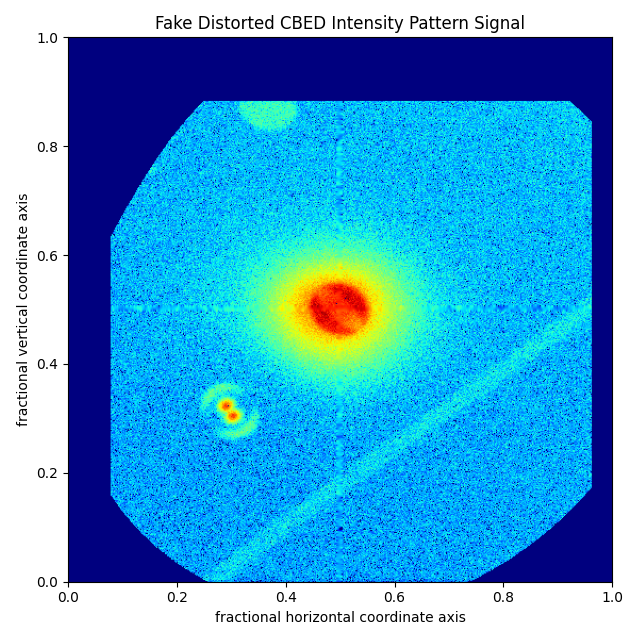

In [33]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.inav[0].plot(**kwargs)

Next, we have the illumination support of the fake CBED pattern. This attribute
stores the same numerical data as ``cbed_pattern.signal.data[1]``, except as a
``PyTorch`` tensor.

In [34]:
cbed_pattern.illumination_support

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

We can visualize the illumination support masked by the mask frame as follows:

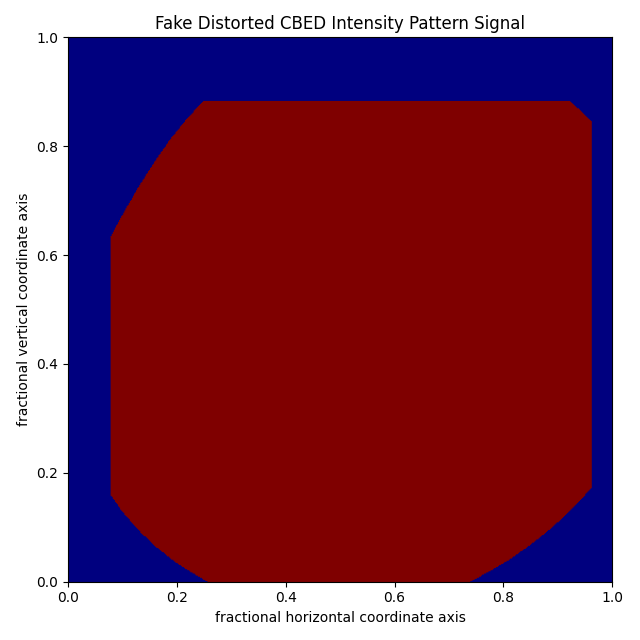

In [35]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.inav[1].plot(**kwargs)

Next, we have the disk overlap support of the fake CBED pattern. This attribute
stores the same numerical data as ``cbed_pattern.signal.data[2]``, except as a
``PyTorch`` tensor.

In [36]:
cbed_pattern.disk_overlap_map

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

We can visualize the disk overlap map as follows:

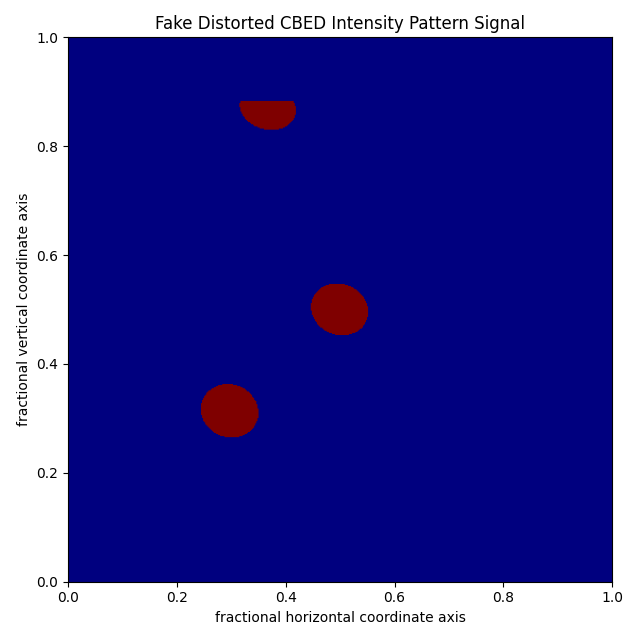

In [37]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.inav[2].plot(**kwargs)

Next, we have the disk supports of the fake CBED pattern. This attribute stores
the same numerical data as ``cbed_pattern.signal.data[3:]``, except as a
``PyTorch`` tensor.

In [38]:
cbed_pattern.disk_supports

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

We can visualize the disk supports as follows:

In [39]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.inav[3:].plot(**kwargs)

Lastly, we have the attribute ``image_has_been_overridden``, which indicates
whether or not the image of the fake CBED pattern has been overridden. In our
current case, the image has not yet been overridden:

In [40]:
cbed_pattern.image_has_been_overridden

False

One can override the image and then subsequently reapply the masks implied by
the illumination support and cold pixels using the method
``override_image_then_reapply_mask``.

In [41]:
N = cbed_pattern.image.shape[0]

overriding_image = np.ones((N, N))
overriding_image[:N//2, :] *= 2

cbed_pattern.override_image_then_reapply_mask(overriding_image)

We should find that the attribute ``image_has_been_overridden`` has been updated
accordingly.

In [42]:
cbed_pattern.image_has_been_overridden

True

We can visualize the overridden image by plotting the signal representation of
the fake CBED pattern again.

In [43]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

### Creating a cropped fake CBED pattern ###

Let us recover the fake CBED pattern we created prior to overriding the image:

In [44]:
kwargs = cbed_pattern.core_attrs
cbed_pattern = fakecbed.discretized.CBEDPattern(**kwargs)

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern.signal.plot(**kwargs)

With this fake CBED pattern we can create a cropped fake CBED pattern:

In [68]:
kwargs = {"cbed_pattern": cbed_pattern, 
          "cropping_window_center": (0.35, 0.35),
          "cropping_window_dims_in_pixels": (300, 300),
          "principal_disk_idx": 1,
          "disk_boundary_sample_size": 64, 
          "mask_frame": (10, 50, 30, 5)}
cropped_cbed_pattern = fakecbed.discretized.CroppedCBEDPattern(**kwargs)

A subset of the attribute names of the
``fakecbed.discretized.CroppedCBEDPattern`` class is equal to the entire set of
attribute names of the ``fakecbed.discretized.CBEDPattern`` class. For instance,
the attribute ``cropped_cbed_pattern.signal`` stores a hyperspy signal
representation of the cropped fake CBED pattern. See
[here](https://mrfitzpa.github.io/fakecbed/_autosummary/fakecbed.discretized.CroppedCBEDPattern.html#fakecbed.discretized.CroppedCBEDPattern.signal)
for a description of the signal representation of the fake cropped CBED pattern.
Note that the image of the discretized cropped CBED pattern is always
automatically min-max normalized. Also, note that the positions of the pixels in
the signal representation of the cropped fake CBED pattern are expressed in the
fractional coordinates of the uncropped fake CBED pattern.

In [69]:
cropped_cbed_pattern_signal = cropped_cbed_pattern.signal

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cropped_cbed_pattern_signal.plot(**kwargs)

cropped_cbed_pattern_signal.metadata

├── FakeCBED
│   ├── cbed_pattern_image_has_been_overridden = False
│   ├── disk_absence_registry = (False, False, True, True, True)
│   ├── disk_clipping_registry = (True, False, True, True, True)
│   ├── num_disks = 5
│   ├── pre_serialized_core_attrs
│   │   ├── cbed_pattern
│   │   │   ├── apply_shot_noise = True
│   │   │   ├── cold_pixels = ((245, 260), (346, 150), (250, 252))
│   │   │   ├── detector_partition_width_in_pixels = 4
│   │   │   ├── distortion_model
│   │   │   │   ├── coord_transform_params
│   │   │   │   │   ├── center = (0.52, 0.49)
│   │   │   │   │   ├── radial_cosine_coefficient_matrix = ((0.0, 0.0, -0.1), (0.0, -0.050000000000000044, 0.0), (0.04949747468305832, 0.0, 0.0))
│   │   │   │   │   ├── radial_sine_coefficient_matrix = ((0.0, -0.08660254037844384), (-0.049497474683058346, 0.0))
│   │   │   │   │   ├── tangential_cosine_coefficient_matrix = ((0.0, 0.0, 0.1), (0.0, -0.02886751345948128, 0.0), (-0.049497474683058346, 0.0, 0.0))
│   │   │   │   │   └── tangential_sine_coefficient_matrix = ((0.0, 0.01666666666666668), (-0.04949747468305832, 0.0))
│   │   │   │   ├── device_name = cpu
│   │   │   │   ├── least_squares_alg_params
│   │   │   │   │   ├── factor_for_decreasing_damping = 9.0
│   │   │   │   │   ├── factor_for_increasing_damping = 11.0
│   │   │   │   │   ├── improvement_tol = 0.1
│   │   │   │   │   ├── initial_damping = 0.001
│   │   │   │   │   ├── max_num_iterations = 20
│   │   │   │   │   ├── plateau_patience = 2
│   │   │   │   │   ├── plateau_tol = 0.001
│   │   │   │   │   └── rel_err_tol = 0.01
│   │   │   │   └── sampling_grid_dims_in_pixels = (512, 512)
│   │   │   ├── gaussian_filter_std_dev = 2.0
│   │   │   ├── mask_frame = (40, 20, 0, 60)
│   │   │   ├── num_pixels_across_pattern = 512
│   │   │   ├── rng_seed = None
│   │   │   ├── undistorted_disks <tuple>
│   │   │   │   ╠══ [0]
│   │   │   │   ║   ╠══ intra_support_shapes <tuple>
│   │   │   │   ║   ║   ╠══ [0]
│   │   │   │   ║   ║   ║   ╠══ center = (0.5, 0.5)
│   │   │   │   ║   ║   ║   ╠══ eccentricity = 0.9
│   │   │   │   ║   ║   ║   ╠══ intra_shape_val = -50.0
│   │   │   │   ║   ║   ║   ╠══ rotation_angle = 0.7853981633974483
│   │   │   │   ║   ║   ║   ╚══ semi_major_axis = 0.05
│   │   │   │   ║   ║   ╠══ [1]
│   │   │   │   ║   ║   ║   ╠══ center = (0.5, 0.5)
│   │   │   │   ║   ║   ║   ╠══ intra_shape_val = 50.0
│   │   │   │   ║   ║   ║   ╚══ radius = 0.05
│   │   │   │   ║   ║   ╚══ [2]
│   │   │   │   ║   ║       ╠══ amplitude = 10.0
│   │   │   │   ║   ║       ╠══ phase = 0.0
│   │   │   │   ║   ║       ╠══ propagation_direction = 2.748893571891069
│   │   │   │   ║   ║       ╚══ wavelength = 0.025
│   │   │   │   ║   ╚══ support
│   │   │   │   ║       ╠══ center = (0.5, 0.5)
│   │   │   │   ║       ╠══ intra_shape_val = 1.0
│   │   │   │   ║       ╚══ radius = 0.05
│   │   │   │   ╠══ [1]
│   │   │   │   ║   ╠══ intra_support_shapes <tuple>
│   │   │   │   ║   ║   ╚══ [0]
│   │   │   │   ║   ║       ╠══ azimuthal_quantum_number = 1
│   │   │   │   ║   ║       ╠══ center = (0.3, 0.3)
│   │   │   │   ║   ║       ╠══ effective_size = 0.005
│   │   │   │   ║   ║       ╠══ magnetic_quantum_number = 0
│   │   │   │   ║   ║       ╠══ principal_quantum_number = 3
│   │   │   │   ║   ║       ╠══ renormalization_factor = 0.01
│   │   │   │   ║   ║       ╚══ rotation_angle = 2.0943951023931953
│   │   │   │   ║   ╚══ support
│   │   │   │   ║       ╠══ center = (0.3, 0.3)
│   │   │   │   ║       ╠══ intra_shape_val = 1.0
│   │   │   │   ║       ╚══ radius = 0.05
│   │   │   │   ╠══ [2]
│   │   │   │   ║   ╠══ intra_support_shapes <tuple>
│   │   │   │   ║   ║   ╠══ [0]
│   │   │   │   ║   ║   ║   ╠══ bg_ellipse
│   │   │   │   ║   ║   ║   ║   ╠══ center = (0.4, 0.98)
│   │   │   │   ║   ║   ║   ║   ╠══ intra_shape_val = 5.0
│   │   │   │   ║   ║   ║   ║   ╚══ radius = 0.05
│   │   │   │   ║   ║   ║   ╚══ fg_ellipse
│   │   │   │   ║   ║   ║       ╠══ center = (0.39, 0.98)
│   │   │   │   ║   ║   ║       ╠══ 

The ``fakecbed.discretized.CroppedCBEDPattern`` class has additional attributes,
one of which is ``principal_disk_is_clipped``, which indicates whether the
"principal" CBED disk is clipped in the image of the cropped fake CBED pattern:

In [70]:
cropped_cbed_pattern.principal_disk_is_clipped

False

In our current example, the principal CBED disk is not clipped. If the principal
CBED disk does not exist, i.e. if the construction parameter
``principal_disk_idx`` is set to a nonnegative integer greater than or equal to
the number of CBED disks defined in the uncropped fake CBED pattern, then
``principal_disk_is_clipped`` will return ``True``. To be clear,
``principal_disk_is_clipped`` can return ``True`` even if the principal CBED
disk exists. In such a scenario, the principal CBED disk corresponds to a CBED
disk that has been defined, but is clipped in the image of the uncropped fake
CBED pattern.

Another attribute is ``principal_disk_is_absent``, which indicates whether the
"principal" CBED disk is absent in the image of the cropped fake CBED pattern:

In [71]:
cropped_cbed_pattern.principal_disk_is_absent

False

In our current example, the principal CBED disk is not absent. If the principal
CBED disk does not exist, then ``principal_disk_is_absent`` will be set to
``True``. To be clear, ``principal_disk_is_absent`` can be set to ``True`` even
if the principal CBED disk exists. In such a scenario, the principal CBED disk
corresponds to a CBED disk that has been defined, but is absent in the image of
the uncropped fake CBED pattern.

Another attribute is
``principal_disk_bounding_box_in_uncropped_image_fractional_coords``, which
stores the bounding box of the unclipped support of the principal CBED disk,
should it exist, in fractional coordinates of the uncropped fake CBED pattern:

In [72]:
attr_name = \
    "principal_disk_bounding_box_in_uncropped_image_fractional_coords"
principal_disk_bounding_box_in_uncropped_image_fractional_coords = \
    getattr(cropped_cbed_pattern, attr_name)

principal_disk_bounding_box_in_uncropped_image_fractional_coords

(0.24377188086509705,
 0.34948647022247314,
 0.2648443877696991,
 0.363150954246521)

In the order that they appear, the coordinates are those of the left, right,
bottom and top sides of the bounding box respectively. If the principal CBED
disk does not exist, then the attribute is set to ``None``.

We can add the box to the signal representations of the cropped and uncropped
fake CBED patterns:

In [73]:
L, R, B, T = principal_disk_bounding_box_in_uncropped_image_fractional_coords

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cropped_cbed_pattern_signal.plot(**kwargs)

try:  # For Hyperspy versions >= 2.
    x_box = (R+L)/2
    y_box = (B+T)/2
    box_center = (x_box, y_box)
    kwargs = {"edgecolors": "green",
              "linewidths": 3, 
              "facecolors": "none",
              "offsets": (box_center,), 
              "widths": (R-L), 
              "heights": (B-T)}
    marker = hs.plot.markers.Rectangles(**kwargs)
except:  # For Hyperspy versions < 2.
    kwargs = {"edgecolor": "green",
              "linewidth": 3, 
              "x1": L, 
              "x2": R, 
              "y1": T, 
              "y2": B}
    marker = hs.plot.markers.rectangle(**kwargs)

cropped_cbed_pattern_signal.add_marker(marker, permanent=False)

In [74]:
cbed_pattern_signal = cbed_pattern.signal

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern_signal.plot(**kwargs)

marker = copy.deepcopy(marker)
cbed_pattern_signal.add_marker(marker, permanent=False)

Another attribute is
``principal_disk_boundary_pts_in_uncropped_image_fractional_coords``, which
stores a sample of points on the boundary of the unclipped support of the
principal CBED disk, should it exist, in fractional coordinates of the uncropped
fake CBED pattern:

In [75]:
attr_name = \
    "principal_disk_boundary_pts_in_uncropped_image_fractional_coords"
principal_disk_boundary_pts_in_uncropped_image_fractional_coords = \
    getattr(cropped_cbed_pattern, attr_name)

principal_disk_boundary_pts_in_uncropped_image_fractional_coords

tensor([[0.3495, 0.3104],
        [0.3492, 0.3152],
        [0.3485, 0.3200],
        [0.3472, 0.3248],
        [0.3455, 0.3294],
        [0.3433, 0.3339],
        [0.3406, 0.3382],
        [0.3375, 0.3423],
        [0.3341, 0.3461],
        [0.3302, 0.3496],
        [0.3261, 0.3527],
        [0.3216, 0.3555],
        [0.3169, 0.3579],
        [0.3120, 0.3599],
        [0.3070, 0.3614],
        [0.3019, 0.3624],
        [0.2967, 0.3630],
        [0.2915, 0.3632],
        [0.2864, 0.3628],
        [0.2813, 0.3620],
        [0.2764, 0.3607],
        [0.2717, 0.3589],
        [0.2673, 0.3568],
        [0.2631, 0.3542],
        [0.2592, 0.3512],
        [0.2558, 0.3478],
        [0.2527, 0.3442],
        [0.2500, 0.3402],
        [0.2478, 0.3360],
        [0.2460, 0.3316],
        [0.2448, 0.3270],
        [0.2440, 0.3223],
        [0.2438, 0.3175],
        [0.2440, 0.3127],
        [0.2448, 0.3078],
        [0.2461, 0.3031],
        [0.2478, 0.2984],
        [0.2501, 0.2939],
        [0.2

If the principal CBED disk does not exist, then the attribute is set to ``None``.

We can add the sample of points to the signal representations of the cropped and
uncropped fake CBED patterns:

In [76]:
pts = principal_disk_boundary_pts_in_uncropped_image_fractional_coords.tolist()

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cropped_cbed_pattern_signal.plot(**kwargs)

markers = tuple()

try:  # For Hyperspy versions >= 2.
    for pt in pts:
        kwargs = {"color": "black", 
                  "sizes": 3, 
                  "offsets": pt}
        marker = hs.plot.markers.Points(**kwargs)
        markers += (marker,)
        cropped_cbed_pattern_signal.add_marker(marker, permanent=False)
except:  # For Hyperspy versions < 2.
    for pt in pts:
        kwargs = {"color": "black", 
                  "size": 3, 
                  "x": pt[0], 
                  "y": pt[1]}
        marker = hs.plot.markers.point(**kwargs)
        markers += (marker,)
        cropped_cbed_pattern_signal.add_marker(marker, permanent=False)

In [77]:
kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cbed_pattern_signal.plot(**kwargs)

markers = copy.deepcopy(markers)

for marker in markers:
    cbed_pattern_signal.add_marker(marker, permanent=False)

Another attribute is
``principal_disk_bounding_box_in_cropped_image_fractional_coords``, which stores
the bounding box of the unclipped support of the principal CBED disk, should it
exist, in fractional coordinates of the cropped fake CBED pattern:

In [78]:
attr_name = \
    "principal_disk_bounding_box_in_cropped_image_fractional_coords"
principal_disk_bounding_box_in_cropped_image_fractional_coords = \
    getattr(cropped_cbed_pattern, attr_name)

principal_disk_bounding_box_in_cropped_image_fractional_coords

(0.3160373568534851,
 0.49645692110061646,
 0.35533440113067627,
 0.5231109857559204)

If the principal CBED disk does not exist, then the attribute is set to ``None``.

In order to add properly the box to the signal representation of the cropped
fake CBED pattern, we need to modify signal axes such that the pixel coordinates
are expressed in fractional units of the cropped fake CBED pattern:

In [79]:
N_h = cropped_cbed_pattern_signal.axes_manager[1].size
N_v = cropped_cbed_pattern_signal.axes_manager[2].size

cropped_cbed_pattern_signal.axes_manager[1].scale = 1/N_h
cropped_cbed_pattern_signal.axes_manager[2].scale = -1/N_v

cropped_cbed_pattern_signal.axes_manager[1].offset = 0.5/N_h
cropped_cbed_pattern_signal.axes_manager[2].offset = 1-(1-0.5)/N_v

cropped_cbed_pattern_signal.axes_manager[1].name = ("fractional horizontal "
                                                    "coordinate of cropped "
                                                    "fake CBED pattern")
cropped_cbed_pattern_signal.axes_manager[2].name = ("fractional vertical "
                                                    "coordinate of cropped "
                                                    "fake CBED pattern")

L, R, B, T = principal_disk_bounding_box_in_cropped_image_fractional_coords

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cropped_cbed_pattern_signal.plot(**kwargs)

try:  # For Hyperspy versions >= 2.
    x_box = (R+L)/2
    y_box = (B+T)/2
    box_center = (x_box, y_box)
    kwargs = {"edgecolors": "green",
              "linewidths": 3, 
              "facecolors": "none",
              "offsets": (box_center,), 
              "widths": (R-L), 
              "heights": (B-T)}
    marker = hs.plot.markers.Rectangles(**kwargs)
except:  # For Hyperspy versions < 2.
    kwargs = {"edgecolor": "green",
              "linewidth": 3, 
              "x1": L, 
              "x2": R, 
              "y1": T, 
              "y2": B}
    marker = hs.plot.markers.rectangle(**kwargs)

cropped_cbed_pattern_signal.add_marker(marker, permanent=False)

Lastly, another attribute is
``principal_disk_boundary_pts_in_cropped_image_fractional_coords``, which stores
a sample of points on the boundary of the unclipped support of the principal
CBED disk, should it exist, in fractional coordinates of the cropped fake CBED
pattern:

In [80]:
attr_name = \
    "principal_disk_boundary_pts_in_cropped_image_fractional_coords"
principal_disk_boundary_pts_in_cropped_image_fractional_coords = \
    getattr(cropped_cbed_pattern, attr_name)

principal_disk_boundary_pts_in_cropped_image_fractional_coords

tensor([[0.4965, 0.4331],
        [0.4960, 0.4413],
        [0.4947, 0.4495],
        [0.4926, 0.4576],
        [0.4896, 0.4655],
        [0.4859, 0.4732],
        [0.4813, 0.4806],
        [0.4761, 0.4875],
        [0.4701, 0.4940],
        [0.4636, 0.5000],
        [0.4565, 0.5054],
        [0.4489, 0.5101],
        [0.4409, 0.5142],
        [0.4325, 0.5175],
        [0.4239, 0.5201],
        [0.4152, 0.5219],
        [0.4063, 0.5229],
        [0.3975, 0.5231],
        [0.3887, 0.5225],
        [0.3801, 0.5211],
        [0.3718, 0.5189],
        [0.3638, 0.5159],
        [0.3561, 0.5122],
        [0.3490, 0.5078],
        [0.3425, 0.5027],
        [0.3365, 0.4970],
        [0.3312, 0.4907],
        [0.3267, 0.4840],
        [0.3229, 0.4768],
        [0.3199, 0.4693],
        [0.3178, 0.4614],
        [0.3165, 0.4534],
        [0.3160, 0.4452],
        [0.3165, 0.4369],
        [0.3178, 0.4287],
        [0.3200, 0.4206],
        [0.3230, 0.4127],
        [0.3268, 0.4050],
        [0.3

If the principal CBED disk does not exist, then the attribute is set to ``None``.

We can add the sample of points to the signal representations of the cropped and
uncropped fake CBED patterns:

In [81]:
pts = principal_disk_boundary_pts_in_cropped_image_fractional_coords.tolist()

kwargs = {"axes_off": False, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.3,
          "cmap": "jet"}
cropped_cbed_pattern_signal.plot(**kwargs)

markers = tuple()

try:  # For Hyperspy versions >= 2.
    for pt in pts:
        kwargs = {"color": "black", 
                  "sizes": 3, 
                  "offsets": pt}
        marker = hs.plot.markers.Points(**kwargs)
        markers += (marker,)
        cropped_cbed_pattern_signal.add_marker(marker, permanent=False)
except:  # For Hyperspy versions < 2.
    for pt in pts:
        kwargs = {"color": "black", 
                  "size": 3, 
                  "x": pt[0], 
                  "y": pt[1]}
        marker = hs.plot.markers.point(**kwargs)
        markers += (marker,)
        cropped_cbed_pattern_signal.add_marker(marker, permanent=False)